In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# for cpu usage only
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2025-09-17 20:09:22.751836: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-17 20:09:22.779180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758114562.794222   33000 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758114562.798710   33000 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758114562.815232   33000 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('omw-1.4')
nlp = spacy.load('en_core_web_sm')

# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    text=text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = nltk.word_tokenize(text)

    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]


    # Step 6: Removing numbers
    tokens = [ word for word in tokens if not word.isdigit()]
    temp=''
    for i in tokens:
        temp=temp+i+' '
    temp.strip()
    return temp

[nltk_data] Downloading package stopwords to /home/haohan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/haohan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/haohan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/haohan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/haohan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Read and combine data

In [3]:
data=pd.read_csv("./Dataset/Restaurant/Restaurants_Train_v2.csv")

data['Sentence']=[preprocess(i) for i in data['Sentence']]
data['Aspect Term']=[preprocess(i) for i in data['Aspect Term']]
data['Combined'] = data['Sentence'].astype(str) + " " + data['Aspect Term'].astype(str)

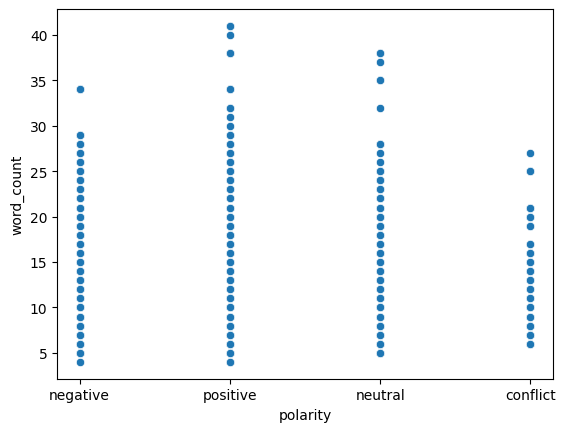

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

word_count=[len(str(i).split(' ')) for i in data['Combined']]
data['word_count']=word_count

sns.scatterplot(data=data,x='polarity',y='word_count')
plt.show()

## Tokenizer + Embedding input

### Making tokenizer

In [5]:
max_word = 3000 # max number of words to consider in the tokenizer
max_len = 45 # max length of a sentence (based on the distribution above)
oov = "<OOV>" # Out-Of-Vocabulary token

tokenizer = Tokenizer(num_words=max_word, oov_token=oov)

texts = data['Combined'].values
tokenizer.fit_on_texts(texts)

In [6]:
tokenizer.num_words
x_seq = tokenizer.texts_to_sequences([texts[0]])

# Actually word thats are mapped to tokens
print(f"Num words: {len(tokenizer.word_index)}")
texts[0], x_seq

Num words: 2954


('staff horribl us  staff ', [[14, 235, 40, 14]])

### Convert text -> sequences -> sequences + pad

In [7]:
X_seq = tokenizer.texts_to_sequences(texts)
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

In [8]:
print(f"Shape input: {X_pad.shape}")
print("Example of padded sequence:\n", X_pad[302])

Shape input: (3693, 45)
Example of padded sequence:
 [827  24 373 258 135 131 765 275  29 243 115 312 276  24  54 110 430 156
 619 390  24   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


## One hot encode labels

In [9]:
le = LabelEncoder()

labels = data['polarity'].values
y = le.fit_transform(data['polarity'])

print(f"Shape output: {y.shape}")
le.classes_.__str__(), np.unique(y).__array__().__str__()

Shape output: (3693,)


("['conflict' 'negative' 'neutral' 'positive']", '[0 1 2 3]')

### Data split (train-val-test 7:1.5:1.5)

In [10]:
X_train, X_val_test, y_train, y_val_test = train_test_split(
    X_pad, y, test_size=0.7, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=42
)

# Use below code if using one-hot encoding 
# from tensorflow.keras.utils import to_categorical
# y_train_onehot = to_categorical(y_train, num_classes=4)
# y_test_onehot  = to_categorical(y_test,  num_classes=4)

X_train.shape,  y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1107, 45), (1107,), (1293, 45), (1293,), (1293, 45), (1293,))

### Plot function

In [11]:
def plot_train_history(history):
    """
    Vẽ biểu đồ loss và accuracy từ Keras training history
    (2 biểu đồ nằm trên cùng một hàng).

    Args:
        history: Keras History object (sau khi train xong model)
    """
    fig, axes = plt.subplots(1, 2, figsize=(14,5))

    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_title('Train/Val Loss per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Accuracy
    axes[1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[1].set_title('Train/Val Accuracy per Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

## Some param before create model

In [12]:
vocab_size = max_word
embedding_dim = 100
num_classes = len(le.classes_)

## RNN

In [13]:
model_rnn = models.Sequential(
    [
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        layers.SimpleRNN(128),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model_rnn.compile(
    loss="sparse_categorical_crossentropy", 
    # loss="categorical_crossentropy", 
    optimizer="adam",
    metrics=["accuracy"]
)

2025-09-17 20:09:26.473684: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-09-17 20:09:26.473720: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-09-17 20:09:26.473730: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-09-17 20:09:26.473735: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-09-17 20:09:26.473740: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: haohan
2025-09-17 20:09:26.473743: I external/local_xla/xla/stream_executor/cuda/cuda_d

In [14]:
history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5547 - loss: 1.1181 - val_accuracy: 0.5878 - val_loss: 1.0373
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5881 - loss: 1.0746 - val_accuracy: 0.5878 - val_loss: 1.0379
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5863 - loss: 1.0648 - val_accuracy: 0.5878 - val_loss: 1.0446
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5827 - loss: 1.0820 - val_accuracy: 0.5878 - val_loss: 1.0441
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5872 - loss: 1.0709 - val_accuracy: 0.5878 - val_loss: 1.0321
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5872 - loss: 1.0669 - val_accuracy: 0.5878 - val_loss: 1.0718
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5872 - loss: 1.0601 - val_accuracy: 0.5878 - val_loss: 1.0369
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5872 - loss: 1.0672 - val_accuracy: 0.5878 - va

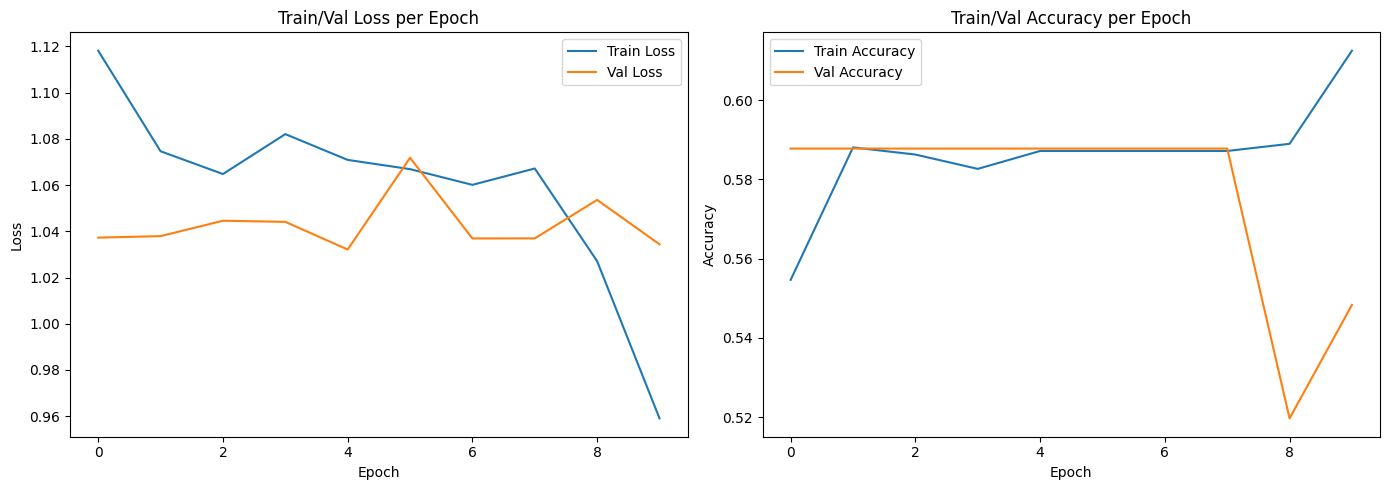

In [15]:
plot_train_history(history_rnn)

In [16]:
y_pred_prob_rnn = model_rnn.predict(X_test)
y_pred_rnn = np.argmax(y_pred_prob_rnn, axis=1)

print(classification_report(y_test, y_pred_rnn, target_names=le.classes_, zero_division=0))

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

    conflict       0.00      0.00      0.00        32
    negative       0.28      0.16      0.20       291
     neutral       0.21      0.23      0.22       216
    positive       0.65      0.78      0.71       754

    accuracy                           0.53      1293
   macro avg       0.29      0.29      0.28      1293
weighted avg       0.48      0.53      0.49      1293



## LSTM

In [17]:
model_lstm = models.Sequential(
    [
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        layers.LSTM(128),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model_lstm.compile(
    loss="sparse_categorical_crossentropy", 
    # loss="categorical_crossentropy", 
    optimizer="adam",
    metrics=["accuracy"]
)

In [18]:
history_lstm = model_rnn.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6332 - loss: 0.9133 - val_accuracy: 0.5893 - val_loss: 1.0424
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6974 - loss: 0.7822 - val_accuracy: 0.5615 - val_loss: 1.1781
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7272 - loss: 0.6722 - val_accuracy: 0.5839 - val_loss: 1.1806
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7353 - loss: 0.6318 - val_accuracy: 0.5963 - val_loss: 1.2209
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7615 - loss: 0.5696 - val_accuracy: 0.5793 - val_loss: 1.2703
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7904 - loss: 0.5194 - val_accuracy: 0.5723 - val_loss: 1.3760
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8238 - loss: 0.4657 - val_accuracy: 0.5770 - val_loss: 1.4197
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.4402 - val_accuracy: 0.5731 - v

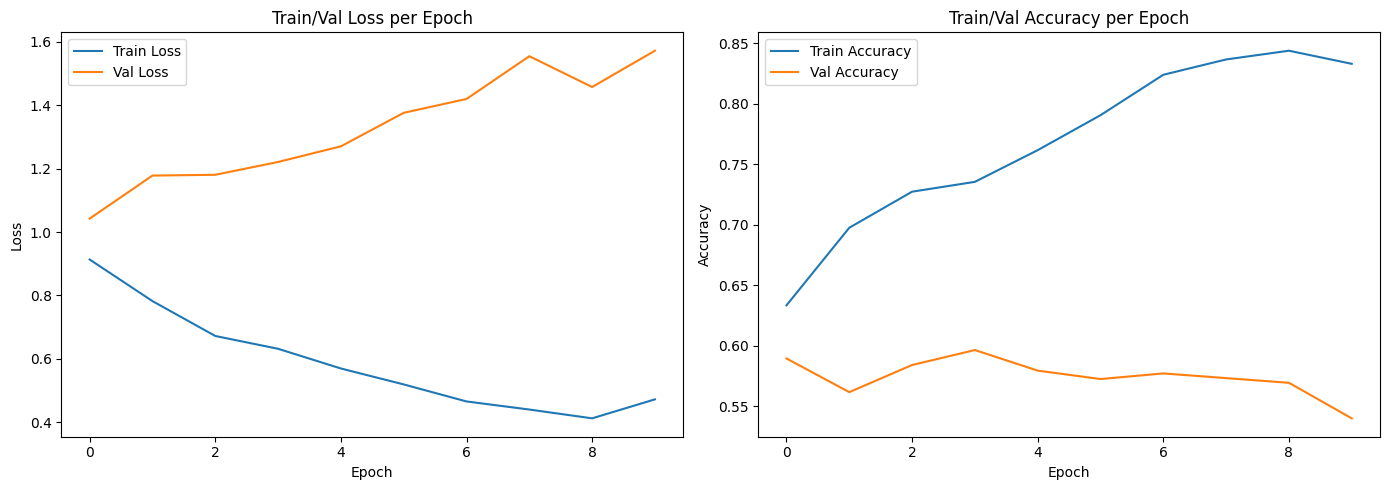

In [19]:
plot_train_history(history_lstm)

In [20]:
y_pred_prob_lstm = model_rnn.predict(X_test)
y_pred_lstm = np.argmax(y_pred_prob_lstm, axis=1)

print(classification_report(y_test, y_pred_lstm, target_names=le.classes_, zero_division=0))

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

    conflict       0.00      0.00      0.00        32
    negative       0.32      0.25      0.28       291
     neutral       0.26      0.34      0.29       216
    positive       0.69      0.72      0.71       754

    accuracy                           0.53      1293
   macro avg       0.32      0.33      0.32      1293
weighted avg       0.52      0.53      0.52      1293

